In [19]:
!pip install --upgrade pip
!pip install pyarrow
!pip install pandas
!pip install duckdb
!pip install hnswlib
!pip install umap-learn
!pip install matplotlib
import pyarrow.parquet as pq
import numpy as np
import pandas as pd
import pyarrow as pa
import duckdb
import hnswlib
import umap


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 32.4 MB/s eta 0:00:00m eta 0:00:010:01:01
  Using cached Pillow-9.2.0-cp39-cp39-macosx_11_0_arm64.whl (2.8 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.2/226.2 kB 8.9 MB/s eta 0:00:00
  Using cached kiwisolver-1.4.4-cp39-cp39-macosx_11_0_arm64.whl (63 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 960.8/960.8 kB 23.5 MB/s eta 0:00:00m eta 0:00:01
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)


In [20]:
context_data_recorder_pq_read = pq.read_table('context_data_recorder.parquet')
context_data_recorder_pq_read_df = context_data_recorder_pq_read.to_pandas()
print("context_data_recorder_pq_read_df", context_data_recorder_pq_read_df.head())
print(context_data_recorder_pq_read_df.iloc[:1]["label"].values[0])

context_data_recorder_pq_read_df                                       embedding_data  \
0  [-0.24175236, -0.17489734, 0.27527738, -0.3626...   
1  [0.1372665, -0.20390767, 0.3732293, -0.2372347...   
2  [-0.106324054, -0.20140041, -0.019513553, -0.2...   
3  [0.20723782, -0.2109229, 0.22755651, -0.188208...   
4  [-0.060116727, -0.10828238, 0.2030715, -0.1245...   

                                        resource_uri  \
0  /Users/jeff/src/chroma/examples/yolov3_embeddi...   
1  /Users/jeff/src/chroma/examples/yolov3_embeddi...   
2  /Users/jeff/src/chroma/examples/yolov3_embeddi...   
3  /Users/jeff/src/chroma/examples/yolov3_embeddi...   
4  /Users/jeff/src/chroma/examples/yolov3_embeddi...   

                             metadata_list  \
0  {'location': 'New York', 'quality': 45}   
1    {'location': 'Dallas', 'quality': 38}   
2        {'location': 'DC', 'quality': 22}   
3        {'location': 'DC', 'quality': 82}   
4     {'location': 'Miami', 'quality': 37}   

                

In [21]:
object_data_recorder_pq_read = pq.read_table('object_data_recorder.parquet')
object_data_recorder_pq_read_df = object_data_recorder_pq_read.to_pandas()
print("object_data_recorder_pq_read_df", object_data_recorder_pq_read_df.head())
print(object_data_recorder_pq_read_df.iloc[:1]["infer"].values[0])

object_data_recorder_pq_read_df                                       embedding_data  \
0  [-0.031979177, -1.2179449, 0.41527477, -0.0050...   
1  [0.38920435, -0.033903435, -0.030004164, 0.477...   
2  [0.29277077, 1.0449085, -0.6858237, 0.23218007...   
3  [0.012765436, 0.31523734, -0.27020937, 0.51416...   
4  [-0.95235604, -1.5869737, -0.029858245, -0.269...   

                                        resource_uri  \
0  /Users/jeff/src/chroma/examples/yolov3_embeddi...   
1  /Users/jeff/src/chroma/examples/yolov3_embeddi...   
2  /Users/jeff/src/chroma/examples/yolov3_embeddi...   
3  /Users/jeff/src/chroma/examples/yolov3_embeddi...   
4  /Users/jeff/src/chroma/examples/yolov3_embeddi...   

                                       metadata_list  \
0  {'iou': 0.9026501178741455, 'score': 0.9997622...   
1          {'iou': 0.0, 'score': 0.8971673846244812}   
2  {'iou': 0.642760157585144, 'score': 0.88095790...   
3  {'iou': 0.6039116978645325, 'score': 0.8784567...   
4  {'iou': 0.8

In [22]:
# print(duckdb.query('''
# SELECT COUNT(*)
# FROM 'test_data_to_record.parquet'
# WHERE metadata.location ILIKE '%San Francisco%';
# ''').fetchall())
print("Record in test")
print(duckdb.query('''
SELECT COUNT(*)
FROM 'context_data_recorder.parquet'
;
''').fetchall())
print("Record in train")
print(duckdb.query('''
SELECT COUNT(*)
FROM 'object_data_recorder.parquet'
;
''').fetchall())

Record in test
[(50,)]
Record in train
[(254,)]


In [23]:
import hnswlib
import numpy as np

#dim = 16
# num_elements = 10000

# Generating sample data
# data = np.float32(np.random.random((num_elements, dim)))

# We split the data in two batches:
data1 = context_data_recorder_pq_read_df['embedding_data'].to_numpy().tolist()
dim = len(data1[0])
num_elements = len(data1) 
# print("dimensionality is:", dim)
# print("total number of elements is:", num_elements)
# print("max elements", num_elements//2)

concatted_data = data1 
# print("concatted_data", len(concatted_data))

# Declaring index
p = hnswlib.Index(space='l2', dim=dim)  # possible options are l2, cosine or ip

# Initing index
# max_elements - the maximum number of elements (capacity). Will throw an exception if exceeded
# during insertion of an element.
# The capacity can be increased by saving/loading the index, see below.
#
# ef_construction - controls index search speed/build speed tradeoff
#
# M - is tightly connected with internal dimensionality of the data. Strongly affects the memory consumption (~M)
# Higher M leads to higher accuracy/run_time at fixed ef/efConstruction

p.init_index(max_elements=len(data1), ef_construction=100, M=16)

# Controlling the recall by setting ef:
# higher ef leads to better accuracy, but slower search
p.set_ef(10)

# Set number of threads used during batch search/construction
# By default using all available cores
p.set_num_threads(4)

# print(data1[0])

# print("Adding first batch of %d elements" % (len(data1)))
p.add_items(data1)

# Query the elements for themselves and measure recall:
labels, distances = p.knn_query(data1, k=1)
print(labels)
print(distances)
print("Recall for the first batch:", np.mean(labels.reshape(-1) == np.arange(len(data1))), "\n")

[[ 0]
 [ 1]
 [ 2]
 [ 3]
 [ 4]
 [ 5]
 [ 6]
 [ 7]
 [ 8]
 [ 9]
 [10]
 [11]
 [12]
 [13]
 [14]
 [15]
 [16]
 [17]
 [18]
 [19]
 [20]
 [21]
 [22]
 [23]
 [24]
 [25]
 [26]
 [27]
 [28]
 [29]
 [30]
 [31]
 [32]
 [33]
 [34]
 [35]
 [36]
 [37]
 [38]
 [39]
 [40]
 [41]
 [42]
 [43]
 [44]
 [45]
 [46]
 [47]
 [48]
 [49]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
Recall for the first batch: 1.0 



In [24]:
def unpack_annotations(embeddings):
    # Get and unpack inference data
    # for embedding in embeddings:
    #     print(embedding)

    annotations = [
        embedding['infer']["annotations"]
        for embedding in embeddings
    ]  # Unpack JSON
    # print("annotations", annotations)
    annotations = [
        annotation for annotation_list in annotations for annotation in annotation_list
    ]  # Flatten the list
    # print("annotations", annotations)

    # categories_by_uid = {
    #     annotation["id"]: annotation["category_id"] for annotation in annotations
    # }
    # print(categories_by_uid)

    # # Unpack embedding data
    embeddings = [embedding["embedding_data"] for embedding in embeddings]

    embedding_vectors_by_category = {}
    for embedding_annotation_pair in zip(embeddings, annotations):
        data = np.array(embedding_annotation_pair[0])
        print("embedding_annotation_pair[1]", embedding_annotation_pair)
        category = embedding_annotation_pair[1]['category_id'] #categories_by_uid[embedding["target"]]
        if category in embedding_vectors_by_category.keys():
            embedding_vectors_by_category[category] = np.append(
                embedding_vectors_by_category[category], data[np.newaxis, :], axis=0
            )
        else:
            embedding_vectors_by_category[category] = data[np.newaxis, :]

    return embedding_vectors_by_category

# Get the training embeddings. This is the set of embeddings belonging to datapoints of the training dataset, and to the first created embedding set.
object_embedding_vectors_by_category = unpack_annotations(object_data_recorder_pq_read_df.to_dict('records'))
print("object_embedding_vectors_by_category", object_embedding_vectors_by_category)
# print("object_data_recorder_pq_read_df.to_dict('records')", object_data_recorder_pq_read_df.head())


embedding_annotation_pair[1] (array([-3.1979177e-02, -1.2179449e+00,  4.1527477e-01, -5.0413376e-03,
        8.4247456e+00, -1.6068657e+01, -1.2856272e+01, -1.7478590e+01,
       -2.0731630e+01, -1.8839205e+01, -1.7973209e+01, -2.4210562e+01,
       -1.9661209e+01, -1.8701141e+01, -2.0141747e+01, -2.1249544e+01,
       -1.6004551e+01, -1.9482801e+01, -1.3259197e+01, -1.8246227e+01,
       -1.4803399e+01, -1.4690562e+01, -1.3864772e+01, -1.4831661e+01,
       -1.6430197e+01, -1.6048841e+01, -1.9659288e+01, -1.5149387e+01,
       -1.7691902e+01, -1.4305431e+01, -1.7037146e+01, -1.3006746e+01,
       -1.6478493e+01, -1.5982117e+01, -1.8372160e+01, -2.3216103e+01,
       -2.1932278e+01, -1.8689098e+01, -1.7029902e+01, -1.9675884e+01,
       -1.7921272e+01, -1.8293982e+01, -1.7425211e+01, -1.3387528e+01,
       -2.0261139e+01, -1.5061267e+01, -1.7976847e+01, -1.5445379e+01,
       -2.0940962e+01, -1.8224489e+01, -1.5778450e+01, -1.7905054e+01,
       -2.0766232e+01, -1.9987213e+01, -1.85170

In [25]:
inv_covs_by_category = {}
means_by_category = {}
for category, embeddings in object_embedding_vectors_by_category.items():
    print(f"Computing mean and covariance for label category {category}")

    # Compute the mean and inverse covariance for computing MHB distance
    print(f"category: {category} samples: {embeddings.shape[0]}")
    if embeddings.shape[0] < (embeddings.shape[1] + 1):
        print(f"not enough samples for stable covariance in category {category}")
        continue
    cov = np.cov(embeddings.transpose())
    try:
        inv_cov = np.linalg.inv(cov)
    except np.linalg.LinAlgError as err:
        print(f"covariance for category {category} is singular")
        continue
    mean = np.mean(embeddings, axis=0)
    inv_covs_by_category[category] = inv_cov
    means_by_category[category] = mean

# print(means_by_category[5])
target_datapoints = object_data_recorder_pq_read_df.to_dict('records') #+ panda_train_table.to_dict('records')
# print(target_datapoints)

# Process each datapoint's inferences individually. This is going to be very slow.
# This is because there is no way to grab the corresponding metadata off the datapoint.
# We could instead put it on the embedding directly ?
inference_metadata = {}
for idx, datapoint in enumerate(target_datapoints):
    inferences = datapoint['infer']["annotations"]
    embeddings = [datapoint["embedding_data"]]

    for i in range(len(inferences)):
        emb_data = embeddings[i]
        category = inferences[i]["category_id"]
        if not category in inv_covs_by_category.keys():
            continue
        mean = means_by_category[category]
        inv_cov = inv_covs_by_category[category]
        delta = np.array(emb_data) - mean
        squared_mhb = np.sum((delta * np.matmul(inv_cov, delta)), axis=0)
        if squared_mhb < 0:
            print(f"squared distance for category {category} is negative")
            continue
        distance = np.sqrt(squared_mhb)
        # print(datapoint)
        inference_metadata[datapoint["resource_uri"]] = distance
        print("distance", distance)

# dict to json
import json


Computing mean and covariance for label category 56
category: 56 samples: 7
not enough samples for stable covariance in category 56
Computing mean and covariance for label category 40
category: 40 samples: 20
not enough samples for stable covariance in category 40
Computing mean and covariance for label category 39
category: 39 samples: 8
not enough samples for stable covariance in category 39
Computing mean and covariance for label category 72
category: 72 samples: 2
not enough samples for stable covariance in category 72
Computing mean and covariance for label category 68
category: 68 samples: 1
not enough samples for stable covariance in category 68
Computing mean and covariance for label category 0
category: 0 samples: 90
Computing mean and covariance for label category 53
category: 53 samples: 1
not enough samples for stable covariance in category 53
Computing mean and covariance for label category 60
category: 60 samples: 6
not enough samples for stable covariance in category 60


In [26]:
def umap_project(vectors):
    reducer = umap.UMAP()
    reducer.fit(vectors)
    projection = reducer.transform(vectors)
    return projection

# get all the embedding_data column from object_data_recorder_pq_read_df
embeddings = object_data_recorder_pq_read_df['embedding_data']
# for embedding_set_id in embedding_set_ids:
#     sql = select(models.EmbeddingSet).where(models.EmbeddingSet.id == embedding_set_id)
#     embedding_set = (db_session.execute(sql)).scalars().first()
#     sql = select(models.Embedding).where(models.Embedding.embedding_set == embedding_set)
#     embeddings = embeddings + ((db_session.execute(sql)).scalars().unique().all())

print(embeddings)
# vectors = [json.loads(emb.data)["data"] for emb in embeddings]
# targets = [json.loads(emb.data)["target"] for emb in embeddings] # load targets to pass them down to Projections
print(f"Fetched data")
projections = umap_project(list(embeddings))
print(f"Calculated projections", projections)



0      [-0.031979177, -1.2179449, 0.41527477, -0.0050...
1      [0.38920435, -0.033903435, -0.030004164, 0.477...
2      [0.29277077, 1.0449085, -0.6858237, 0.23218007...
3      [0.012765436, 0.31523734, -0.27020937, 0.51416...
4      [-0.95235604, -1.5869737, -0.029858245, -0.269...
                             ...                        
249    [0.7585952, 1.3949387, -0.52482027, 0.2589881,...
250    [0.014012797, -0.18442616, -0.045814347, 0.239...
251    [-0.7796049, -2.0646446, 0.82665193, -0.419909...
252    [0.4160559, 0.3451413, -0.043667912, -0.293661...
253    [-1.8091856, 1.1046584, -7.18998e-05, -0.36695...
Name: embedding_data, Length: 254, dtype: object
Fetched data
Calculated projections [[ 6.782945    6.4979568 ]
 [ 0.32437447  9.290492  ]
 [ 2.1506686   9.219686  ]
 [ 0.47870013  9.30675   ]
 [ 5.203249   10.0019245 ]
 [ 0.4460521   9.234472  ]
 [ 2.3251073   9.234124  ]
 [ 0.54288304  9.2200365 ]
 [ 2.473996    9.326302  ]
 [ 5.3903885  10.244686  ]
 [ 0.6523305   9.0

In [32]:
print(distances)
# i need realish data... so i get realish distances, so i can get realish projection coloring

[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


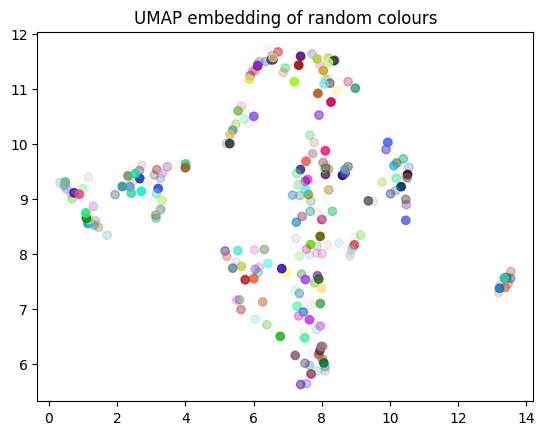

In [30]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
data = np.random.rand(len(projections), 4)
plt.scatter(projections[:,0], projections[:,1], c=data)
plt.title('UMAP embedding of random colours');